In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Add, PReLU, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19 # Perceptual Loss uses high-level feature maps of the VGG network (Used in discriminator) - instead of MSE-based content loss

In [ ]:
import cv2
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

Original paper: https://arxiv.org/pdf/1609.04802

Original Paper Uses 4x upscaling architecture. We Adopted their approach to limit it on 2x by removing the upsamplying layer of the generator and reducing the number of downsampling layers in the discriminator to match the new scale factor.

## Image Dataset preprocessing

In [ ]:
ds_train = tfds.load('div2k/bicubic_x2', split='train')

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.HNM1PT_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.HNM1PT_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x2/2.0.0. Subsequent calls will reuse this data.


In [ ]:
def train_low(ds_train, size, scale):
    data = []
    for example in ds_train:
        hr_image = example['hr'].numpy()  # Extract high-resolution image

        # downsample and upsample using bicubic interpolation
        img = cv2.resize(hr_image, (size, size), cv2.INTER_CUBIC)
        img = img.astype(float) / 255

        data.append(img)

    data = np.array(data)

    return data

In [ ]:
y_train_low = train_low(ds_train, 128, 2)

In [ ]:
y_train_low.shape

(800, 128, 128, 3)

In [ ]:
def train_high(ds_train, size):
    data = []
    for example in ds_train:
        hr_image = example['hr'].numpy()  # extract high-resolution image

        img = cv2.resize(hr_image, (size, size))

        img = img.astype(float) / 255

        data.append(img)

    data = np.array(data)

    return data

In [ ]:
X_train_high = train_high(ds_train, 256)

In [ ]:
X_train_high.shape

(800, 256, 256, 3)

Text(0.5, 1.0, 'high resolution ')

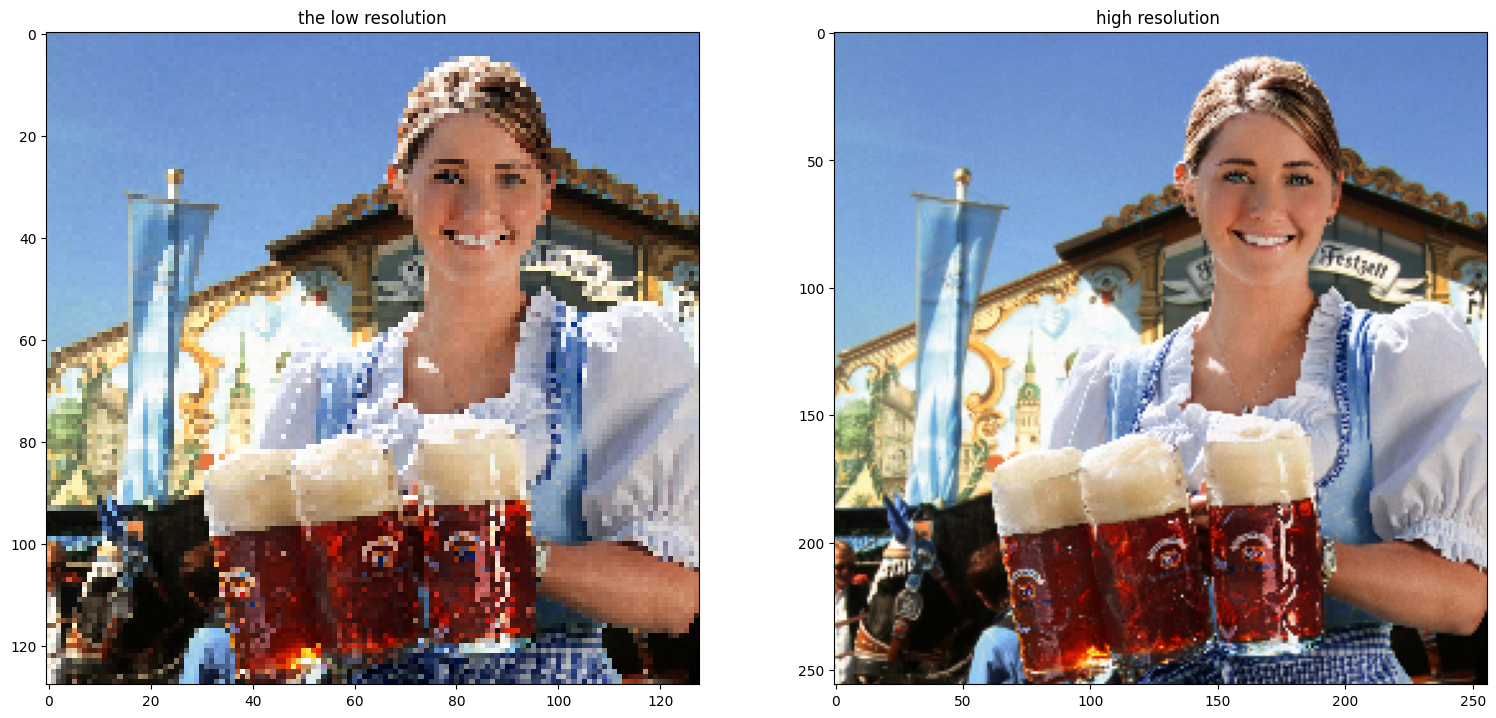

In [ ]:
# Show an image exmpales from the learning DS


plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(y_train_low[5])
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(X_train_high[5])
plt.title("high resolution ")

## SRGAN architecture

### Generator

In [ ]:
# Generator
def res_block(x):
    """
    Residual Block - fundamental building block of Generator
    :param x: input tensor
    :return: output tensor
    """
    filters = 64
    shortcut = x # original input is saved to be added later.
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x) # Convolutional layers with 64 filters and a 3x3 kernel
    x = BatchNormalization()(x) # Normalizes the activations 2x momentum = 0.8
    x = PReLU(shared_axes=[1, 2])(x) # Parametric ReLU activaiton function
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x) # momentum = 0.8 2x

    x = Add()([shortcut, x]) # Adds the input to the output of the covolutions (skip connection)
    return x

In [ ]:
def upsample(x):
    """
    Upsampling layer, increases the spatial dimensions of the input tensor by a factor of 2
    :param x: input tensor
    :return: output tensor
    """
    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Pixel shuffle operation that increases the spatial resolutin by rearranging the depths dimension into spatial dimetnsions.
    x = PReLU(shared_axes=[1, 2])(x)
    return x

In [ ]:
def generator():
    """
    Generator architecture - generates high-resolution images from low-resolution ones
    :return: Generator model
    """
    inputs = Input(shape=(128, 128, 3)) #2x: last number was 3;
    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(inputs) # Captures low-level features
    x = PReLU(shared_axes=[1, 2])(x)

    shortcut = x # original input is saved to be added later.
    # 16 residual bocks are applied sequentially to extract high-level features.
    for _ in range(16):  #TODO: Experiment, 2x: maybe decrease for 2x upscaling
        x = res_block(x)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])

    # two upsampling blocks are used to increase the resolution of the feature maps.
    x = upsample(x)
    # x = upsample(x) #2x - removing to scale only in two times

    # final layer; converts the upsampled features back to 3 color channels with a tanh activation - to prduce the final high-resolution image.
    x = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(x)
    return Model(inputs, x, name='generator')

### Discriminator

In [ ]:
def discriminator():
    """
    Discriminator architecture - distinguishes between real high-resolution images and those generated by the generator
    :return: Discriminator model
    """
    inputs = Input(shape=(256, 256, 3)) #2x: last number was 3;
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs) # Captures low-level features
    # x = PReLU(shared_axes=[1, 2])(x) # 2x - removed
    x = LeakyReLU(alpha=0.2)(x)

    for filters in [64, 128, 256, 512]:  #[64, 128, 128, 256, 256, 512, 512]: # 2x
        x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x) #
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = BatchNormalization()(x) #
        x = LeakyReLU(alpha=0.2)(x)



    x = Flatten()(x) #  converts the 4D tensor to 1D tensor.
    x = Dense(1024)(x) # fully connected layer with 1024 units.
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x) # final dense layer with a sigmoid activation to classify the input as real or fake
    return Model(inputs, x, name='discriminator')

### Loss Function + VGG

In [ ]:
def build_vgg19():
    '''
    VGG19 LOSS:
    Building VGG (Visual Geometry Group)) network to extract image features for perceptual loss calculation.

    '''
    input_shape = (256, 256, 3)
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=input_shape) #2x: added input_shape = (256, 256, 3)
    # include_top - False - we don't need final classification layer. We only need the convolutional layers.
    return Model(vgg.input, vgg.layers[10].output) # Changed - second parameter: vgg.get_layer('block5_conv4').output;  from   Model(inputs = vgg.inputs, outputs = vgg.layers[10].ouput)  - we can add that back


vgg = build_vgg19()


# When using VGG, convert single-channel to 3-channel
def to_3channel(x):
    return tf.tile(x, [1, 1, 1, 3])


80134624/80134624 [==============================] - 4s 0us/step


VGG22 VGG54 also could be used as loss calculation approaches (improve feature extraction)


VGG22 (Layer 2-2): Captures relatively low-level features, such as textures and edges.

VGG54 (Layer 5-4): Captures high-level features, such as object parts and more abstract representations.

## Build Models & optimizers



In [ ]:
# Optimizers
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)
common_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)

In [ ]:
# Build models
gen = generator()
gen.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         15616     ['input_2[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 128, 128, 64)         64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['p_re_lu[0][0]']             
                                                                                          

In [ ]:
disc = discriminator()
disc.compile(loss="binary_crossentropy", optimizer=disc_optimizer, metrics=['accuracy']) # added
disc.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_33 (Ba  (None, 256, 256, 64)      256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 64)      0         
                                                     

In [ ]:
vgg = build_vgg19()
vgg.trainable = False # added
vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy']) # added
vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

### Build and compile the adverisal model - v2


In [ ]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.


# High res. and low res. images
input_high_resolution = Input(shape=(256, 256, 3))
input_low_resolution = Input(shape=(128, 128, 3))

# Generate high-resolution images from low-resolution images
generated_high_resolution_images = gen(input_low_resolution)

# Extract feature maps of the generated images - content loss
features = vgg(generated_high_resolution_images)

# Make the discriminator network as trainable false
disc.trainable = False

# Get the probability (validity) of generated high-resolution images - adversial loss
probs = disc(generated_high_resolution_images)

# Create and compile an adversarial model combining
gan_model = Model([input_low_resolution, input_high_resolution], [probs, features])
gan_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1],
                          optimizer=common_optimizer)
gan_model.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 256, 256, 3)          1407107   ['input_12[0][0]']            
                                                                                                  
 input_11 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 discriminator (Functional)  (None, 1)                    1389497   ['generator[0][0]']           
                                                          61                                



## Training model



In [ ]:
from google.colab import drive # Mount Google drive
import os

drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/SRGAN_checkpoints/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


Mounted at /content/drive


In [ ]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((y_train_low, X_train_high))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(1)

In [ ]:

# # Loss functions
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()
@tf.function
def train_step(lr_images, hr_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(lr_images, training=True)

        # Discriminator outpu for real and fake high-resolution images
        real_output = disc(hr_images, training=True)
        fake_output = disc(generated_images, training=True)

        # Discriminator loss
        disc_real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)  # Calculate discriminator loss for real images (should classify as real, hence using ones)
        disc_fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)  # Calculate discriminator loss for fake images (should classify as fake, hence using zeros)

        # Total discriminator loss
        disc_loss = disc_real_loss + disc_fake_loss

        # Generator loss (adversairal loss), basically, binary cross enthropy - to fool the discriminator (hense using ones)
        gen_loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)

        # Content loss using MSE between feature maps generated by the VGG
        content_loss = mse(vgg(hr_images), vgg(generated_images))

        # Perceptual loss
        perceptual_loss = content_loss + 0.001 * gen_loss  # !


     # Compute gradients for the generator
    gen_gradients = gen_tape.gradient(perceptual_loss, gen.trainable_variables)
    # Compute gradients for the discriminator
    disc_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)

    # Apply the gradients to the optimizer for updating generator weights
    gen_optimizer.apply_gradients(zip(gen_gradients, gen.trainable_variables))
    # Apply the gradients to the optimizer for updating discriminator weights
    disc_optimizer.apply_gradients(zip(disc_gradients, disc.trainable_variables))

    return perceptual_loss, disc_loss # content_loss

Training Loop

In [ ]:
# v1 - up to this moment seems legit
from tqdm import tqdm
import time
import json

training_info = {}

epochs = 75
for epoch in range(epochs):
    start_time = time.time()

    # Lists to store losses
    perceptual_losses = []
    disc_losses = []

    # Iterate over batches
    for lr_batch, hr_batch in tqdm(train_dataset):
        perceptual_loss, disc_loss = train_step(lr_batch, hr_batch)
        perceptual_losses.append(perceptual_loss)
        disc_losses.append(disc_loss)

    # Compute average losses for the epoch
    avg_perceptual_loss = float(tf.reduce_mean(perceptual_losses).numpy())
    avg_disc_loss = float(tf.reduce_mean(disc_losses).numpy())

    #Report the progress during training.
    print(f"Epoch {epoch+1}/{epochs}: Time taken: {time.time() - start_time:.2f} seconds\n")
    print(f"Generator Loss: {avg_perceptual_loss:.4f}")
    print(f"Discriminator Loss: {avg_disc_loss:.4f}")

    training_info[epoch+1] = (avg_perceptual_loss, avg_disc_loss, time.time() - start_time) # log training data

    if epoch % 5 == 0:
      gen.save(os.path.join(save_dir, f"gen_e_{epoch+1}.tf"))
      print(f"Model saved at epoch {epoch+1}")
      with open(os.path.join(save_dir, f"training_info.json"), 'w') as f:
          json.dump(training_info, f)



100%|██████████| 800/800 [02:22<00:00,  5.62it/s]


Epoch 1/75: Time taken: 142.46 seconds

Generator Loss: 26.8609
Discriminator Loss: 4.3301
Model saved at epoch 1


100%|██████████| 800/800 [02:22<00:00,  5.61it/s]


Epoch 2/75: Time taken: 142.64 seconds

Generator Loss: 24.8640
Discriminator Loss: 1.0359


100%|██████████| 800/800 [02:22<00:00,  5.62it/s]


Epoch 3/75: Time taken: 142.35 seconds

Generator Loss: 23.5626
Discriminator Loss: 0.8556


100%|██████████| 800/800 [02:22<00:00,  5.63it/s]


Epoch 4/75: Time taken: 142.19 seconds

Generator Loss: 22.8138
Discriminator Loss: 0.9941


100%|██████████| 800/800 [02:22<00:00,  5.63it/s]


Epoch 5/75: Time taken: 142.24 seconds

Generator Loss: 22.0881
Discriminator Loss: 1.0042


100%|██████████| 800/800 [02:22<00:00,  5.63it/s]


Epoch 6/75: Time taken: 142.23 seconds

Generator Loss: 21.3890
Discriminator Loss: 0.6250
Model saved at epoch 6


100%|██████████| 800/800 [02:22<00:00,  5.62it/s]


Epoch 7/75: Time taken: 142.37 seconds

Generator Loss: 21.0737
Discriminator Loss: 0.4132


100%|██████████| 800/800 [02:21<00:00,  5.65it/s]


Epoch 8/75: Time taken: 141.73 seconds

Generator Loss: 20.6350
Discriminator Loss: 0.1415


100%|██████████| 800/800 [02:21<00:00,  5.65it/s]


Epoch 9/75: Time taken: 141.53 seconds

Generator Loss: 20.2672
Discriminator Loss: 0.0018


100%|██████████| 800/800 [02:21<00:00,  5.63it/s]


Epoch 10/75: Time taken: 142.02 seconds

Generator Loss: 19.8057
Discriminator Loss: 0.8059


100%|██████████| 800/800 [02:22<00:00,  5.60it/s]


Epoch 11/75: Time taken: 142.78 seconds

Generator Loss: 19.5482
Discriminator Loss: 0.2539
Model saved at epoch 11


100%|██████████| 800/800 [02:21<00:00,  5.65it/s]


Epoch 12/75: Time taken: 141.72 seconds

Generator Loss: 19.4179
Discriminator Loss: 0.0041


100%|██████████| 800/800 [02:21<00:00,  5.65it/s]


Epoch 13/75: Time taken: 141.74 seconds

Generator Loss: 19.1222
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:22<00:00,  5.63it/s]


Epoch 14/75: Time taken: 142.09 seconds

Generator Loss: 18.7619
Discriminator Loss: 0.6731


100%|██████████| 800/800 [02:22<00:00,  5.61it/s]


Epoch 15/75: Time taken: 142.70 seconds

Generator Loss: 18.5216
Discriminator Loss: 0.3187


100%|██████████| 800/800 [02:22<00:00,  5.61it/s]


Epoch 16/75: Time taken: 142.73 seconds

Generator Loss: 18.3709
Discriminator Loss: 0.2183
Model saved at epoch 16


100%|██████████| 800/800 [02:22<00:00,  5.61it/s]


Epoch 17/75: Time taken: 142.53 seconds

Generator Loss: 18.1480
Discriminator Loss: 0.1575


100%|██████████| 800/800 [02:21<00:00,  5.65it/s]


Epoch 18/75: Time taken: 141.63 seconds

Generator Loss: 17.9105
Discriminator Loss: 0.1358


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 19/75: Time taken: 143.16 seconds

Generator Loss: 17.6236
Discriminator Loss: 0.1581


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 20/75: Time taken: 143.24 seconds

Generator Loss: 17.4118
Discriminator Loss: 0.1506


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 21/75: Time taken: 143.20 seconds

Generator Loss: 17.2478
Discriminator Loss: 0.0921
Model saved at epoch 21


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 22/75: Time taken: 143.42 seconds

Generator Loss: 17.4727
Discriminator Loss: 0.1767


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 23/75: Time taken: 143.27 seconds

Generator Loss: 16.8250
Discriminator Loss: 0.1961


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 24/75: Time taken: 143.28 seconds

Generator Loss: 16.6482
Discriminator Loss: 0.0132


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 25/75: Time taken: 143.52 seconds

Generator Loss: 16.5145
Discriminator Loss: 0.1017


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 26/75: Time taken: 143.37 seconds

Generator Loss: 16.2441
Discriminator Loss: 0.0000
Model saved at epoch 26


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 27/75: Time taken: 143.51 seconds

Generator Loss: 16.0184
Discriminator Loss: 0.0001


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 28/75: Time taken: 143.34 seconds

Generator Loss: 15.8139
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 29/75: Time taken: 143.21 seconds

Generator Loss: 15.5838
Discriminator Loss: 0.0000


100%|██████████| 800/800 [03:21<00:00,  3.96it/s]


Epoch 30/75: Time taken: 201.92 seconds

Generator Loss: 15.4428
Discriminator Loss: 0.1001


100%|██████████| 800/800 [02:22<00:00,  5.60it/s]


Epoch 31/75: Time taken: 143.00 seconds

Generator Loss: 15.7693
Discriminator Loss: 0.2909
Model saved at epoch 31


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 32/75: Time taken: 143.57 seconds

Generator Loss: 15.5759
Discriminator Loss: 0.0637


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 33/75: Time taken: 143.43 seconds

Generator Loss: 14.9368
Discriminator Loss: 0.0008


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 34/75: Time taken: 143.51 seconds

Generator Loss: 14.5939
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 35/75: Time taken: 143.33 seconds

Generator Loss: 14.5160
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 36/75: Time taken: 143.52 seconds

Generator Loss: 14.3088
Discriminator Loss: 0.0000
Model saved at epoch 36


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 37/75: Time taken: 143.24 seconds

Generator Loss: 14.0442
Discriminator Loss: 0.1776


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 38/75: Time taken: 143.25 seconds

Generator Loss: 13.8541
Discriminator Loss: 0.0689


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 39/75: Time taken: 143.37 seconds

Generator Loss: 13.6294
Discriminator Loss: 0.1201


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 40/75: Time taken: 143.57 seconds

Generator Loss: 13.4949
Discriminator Loss: 0.0745


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 41/75: Time taken: 143.21 seconds

Generator Loss: 13.3549
Discriminator Loss: 0.0851
Model saved at epoch 41


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 42/75: Time taken: 143.46 seconds

Generator Loss: 13.0503
Discriminator Loss: 0.1468


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 43/75: Time taken: 143.75 seconds

Generator Loss: 12.9272
Discriminator Loss: 0.0003


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 44/75: Time taken: 143.28 seconds

Generator Loss: 12.7152
Discriminator Loss: 0.0696


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 45/75: Time taken: 143.39 seconds

Generator Loss: 12.6335
Discriminator Loss: 0.0296


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 46/75: Time taken: 143.43 seconds

Generator Loss: 12.3915
Discriminator Loss: 0.0791
Model saved at epoch 46


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 47/75: Time taken: 143.60 seconds

Generator Loss: 12.2883
Discriminator Loss: 0.0549


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 48/75: Time taken: 143.20 seconds

Generator Loss: 12.1802
Discriminator Loss: 0.0375


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 49/75: Time taken: 143.42 seconds

Generator Loss: 11.9257
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 50/75: Time taken: 143.40 seconds

Generator Loss: 11.8164
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 51/75: Time taken: 143.14 seconds

Generator Loss: 11.6865
Discriminator Loss: 0.0000
Model saved at epoch 51


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 52/75: Time taken: 143.64 seconds

Generator Loss: 11.4964
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 53/75: Time taken: 143.40 seconds

Generator Loss: 11.4800
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 54/75: Time taken: 143.62 seconds

Generator Loss: 11.2612
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 55/75: Time taken: 143.35 seconds

Generator Loss: 11.1045
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 56/75: Time taken: 143.48 seconds

Generator Loss: 11.1018
Discriminator Loss: 0.0000
Model saved at epoch 56


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 57/75: Time taken: 143.67 seconds

Generator Loss: 10.9883
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 58/75: Time taken: 143.38 seconds

Generator Loss: 10.8059
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 59/75: Time taken: 143.63 seconds

Generator Loss: 10.7520
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 60/75: Time taken: 143.61 seconds

Generator Loss: 11.9591
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 61/75: Time taken: 143.60 seconds

Generator Loss: 11.6724
Discriminator Loss: 0.0000
Model saved at epoch 61


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 62/75: Time taken: 143.69 seconds

Generator Loss: 10.4965
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 63/75: Time taken: 143.33 seconds

Generator Loss: 10.2903
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 64/75: Time taken: 143.68 seconds

Generator Loss: 10.2070
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 65/75: Time taken: 143.61 seconds

Generator Loss: 10.1832
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 66/75: Time taken: 143.62 seconds

Generator Loss: 10.4719
Discriminator Loss: 0.0000
Model saved at epoch 66


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 67/75: Time taken: 143.66 seconds

Generator Loss: 10.0304
Discriminator Loss: 0.0564


100%|██████████| 800/800 [02:22<00:00,  5.60it/s]


Epoch 68/75: Time taken: 142.86 seconds

Generator Loss: 10.0121
Discriminator Loss: 0.2814


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 69/75: Time taken: 143.58 seconds

Generator Loss: 9.8634
Discriminator Loss: 0.0181


100%|██████████| 800/800 [03:21<00:00,  3.96it/s]


Epoch 70/75: Time taken: 201.92 seconds

Generator Loss: 9.8801
Discriminator Loss: 0.0000


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 71/75: Time taken: 143.56 seconds

Generator Loss: 9.8218
Discriminator Loss: 0.0000
Model saved at epoch 71


100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


Epoch 72/75: Time taken: 143.58 seconds

Generator Loss: 9.7496
Discriminator Loss: 0.1298


100%|██████████| 800/800 [02:23<00:00,  5.59it/s]


Epoch 73/75: Time taken: 143.17 seconds

Generator Loss: 9.5669
Discriminator Loss: 0.0622


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 74/75: Time taken: 143.46 seconds

Generator Loss: 9.5014
Discriminator Loss: 0.0632


100%|██████████| 800/800 [02:23<00:00,  5.58it/s]


Epoch 75/75: Time taken: 143.38 seconds

Generator Loss: 9.5231
Discriminator Loss: 0.0588


In [ ]:
gen.save(os.path.join(save_dir, f"gen_e_{epoch+1}.tf"))
print(f"Model saved at epoch {epoch+1}")

Model saved at epoch 75





## Testing and Exploring results

### Analysing the training process


In [ ]:
def show_images(low_resolution_image, generated_image, original_image, path=''):
    """
    Save images in a single figure
    """

    plt.figure(figsize = (100, 100))

    ax = plt.subplot(10, 10, 1)
    plt.imshow(low_resolution_image)
    plt.title("Low resolution")

    ax = plt.subplot(10, 10, 2)
    plt.imshow(generated_image)
    plt.title("Generated ")

    ax = plt.subplot(10, 10, 3)
    plt.imshow(original_image)
    plt.title("High Resolution")


    # plt.savefig(path)  - save images if needed

In [ ]:
def super_resolve_image(model, image_path):
    low_res_image = cv2.imread(image_path)
    low_res_image = cv2.cvtColor(low_res_image, cv2.COLOR_BGR2RGB)
    low_res_image = cv2.resize(low_res_image, (128, 128))
    low_res_image = low_res_image.astype(float) / 255
    low_res_image = np.expand_dims(low_res_image, axis=0) # otherwise won't work

    sr_image = model.predict(low_res_image)
    sr_image = np.squeeze(sr_image, axis=0) # because the dimensions of generetated image - 1, 256, 256, 3
    sr_image = (sr_image * 255.0).astype('uint8') # ! - test

    return sr_image

In [ ]:
def srgan_load_and_predict(model_path, image_path):
    model = tf.keras.models.load_model(model_path, compile=False)
    sr_image = super_resolve_image(model, image_path)
    return sr_image

In [ ]:
import matplotlib.pyplot as plt

def show_training_data(loaded_dict):
  # Extract data for plotting
  epochs = list(loaded_dict.keys())
  perceptual_losses = [loaded_dict[epoch][0] for epoch in epochs]
  disc_losses = [loaded_dict[epoch][1] for epoch in epochs]
  training_times = [loaded_dict[epoch][2] for epoch in epochs]

  # Plotting the metrics
  plt.figure(figsize=(14, 6))

  plt.subplot(1, 3, 1)
  plt.plot(epochs, perceptual_losses, label='Perceptual Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Perceptual Loss')
  plt.title('Perceptual Loss per Epoch')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(epochs, disc_losses, label='Discriminator Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Discriminator Loss')
  plt.title('Discriminator Loss per Epoch')
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.plot(epochs, training_times, label='Training Time')
  plt.xlabel('Epoch')
  plt.ylabel('Time (s)')
  plt.title('Training Time per Epoch')
  plt.legend()

  plt.tight_layout()
  plt.show()


In [ ]:
from google.colab import drive # Mount Google drive
import json

drive.mount('/content/drive')

# Save the dictionary to a file
log_file_path = '/content/drive/MyDrive/SRGAN_checkpoints/training_logs.json'

# Load the dictionary from the file
with open(log_file_path, 'r') as f:
    loaded_dict = json.load(f)

print("Loaded dictionary:", loaded_dict)

In [ ]:
# Show training data:
show_training_data(loaded_dict)

In [ ]:
SRGAN = gen # in case we are not importing already saved model. Run either of the cells, depedning on the situation

In [ ]:
from google.colab import drive # Mount Google drive
from keras.models import load_model
from numpy.random import randint
import os

drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/SRGAN_checkpoints/"
model_path = "gen_e_10.tf"

SRGAN = load_model(os.path.join(save_dir, model_path), compile=False)



(128, 128, 3)
(1, 128, 128, 3)
1/1 [==============================] - 0s 26ms/step


(1, 256, 256, 3)


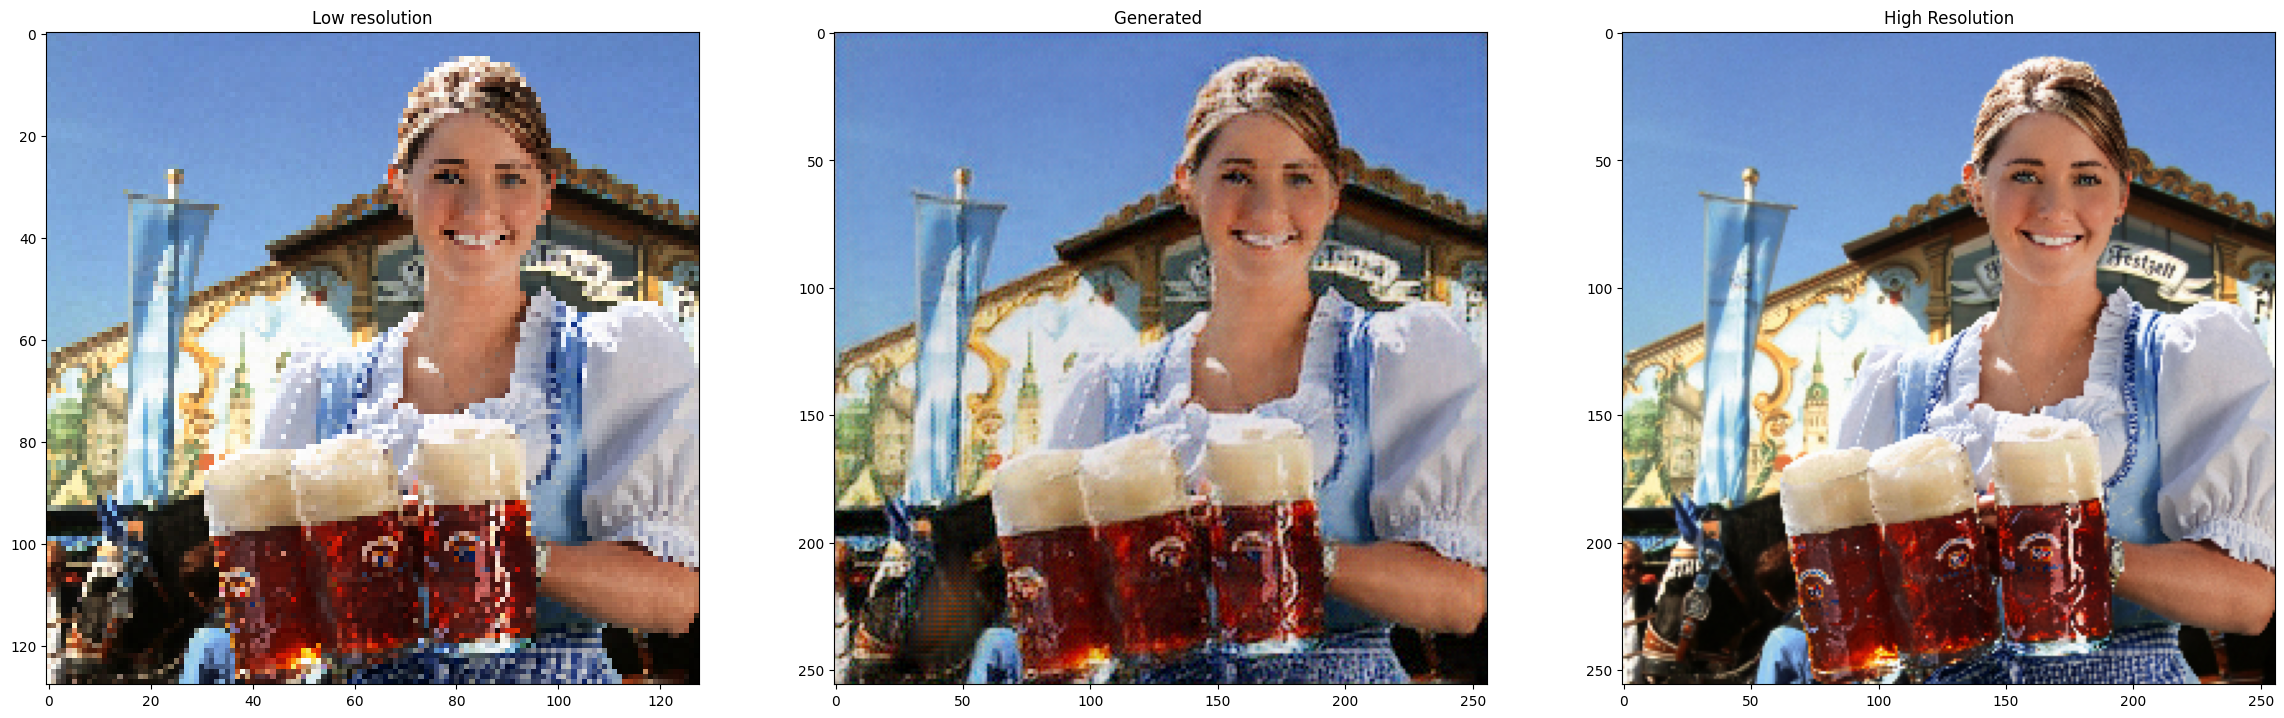

In [ ]:
low_res_image = y_train_low[5]
high_res_image = X_train_high[5]
print(low_res_image.shape)

low_res_image_expanded = np.expand_dims(low_res_image, axis=0)
print(low_res_image_expanded.shape)

sr_image = SRGAN.predict(low_res_image_expanded)
print(sr_image.shape)

show_images(low_res_image, sr_image[0], high_res_image)